[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Initial Balance: $100000.00
Final Balance: $311374.37
NVIDIA Average Return: 0.8978
AMD Average Return: 0.1461
NVIDIA Win Ratio: 100.00%
AMD Win Ratio: 100.00%


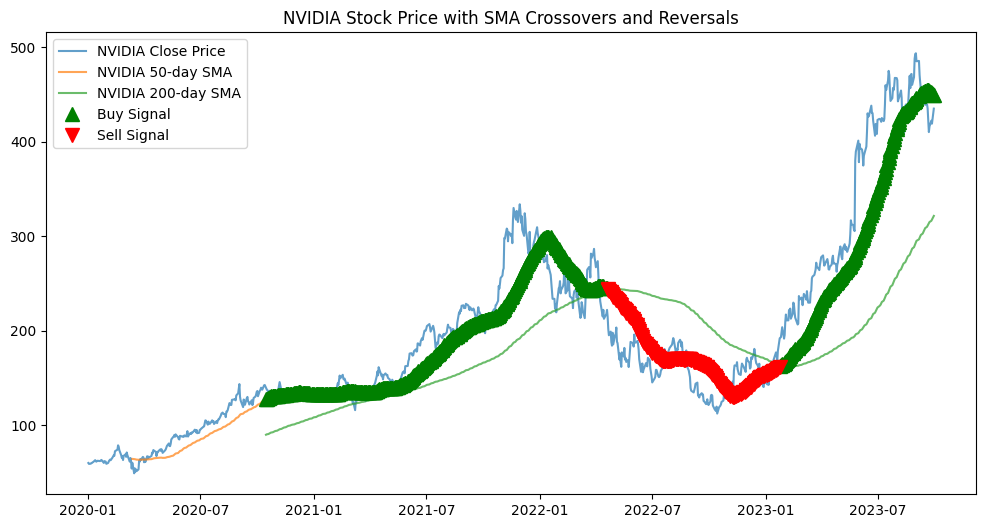

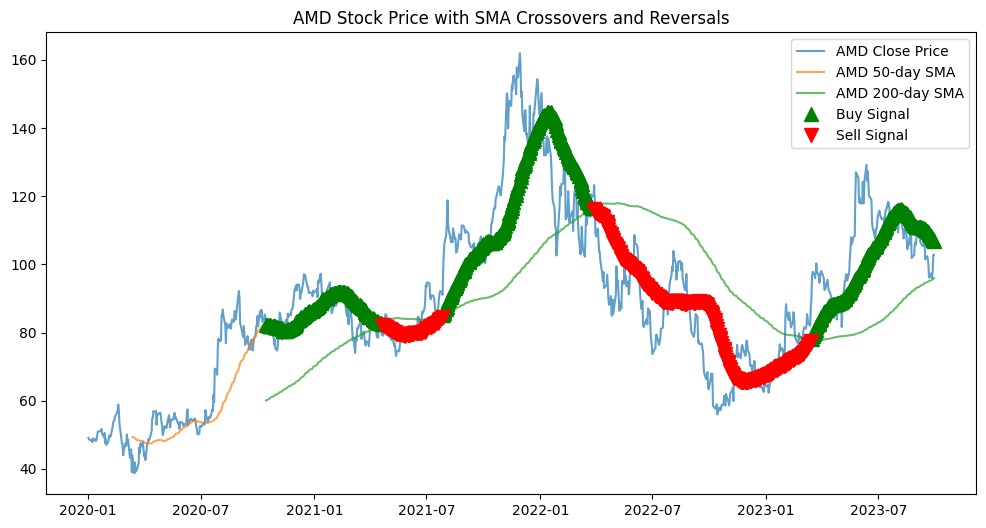

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the stock symbols and time period
symbols = ['NVDA', 'AMD']
start_date = '2020-01-01'
end_date = '2023-10-01'

# Fetch historical stock data for NVIDIA and AMD
nvidia_data = yf.download(symbols[0], start=start_date, end=end_date)
amd_data = yf.download(symbols[1], start=start_date, end=end_date)

# Calculate SMA for NVIDIA and AMD
short_window = 50
long_window = 200

nvidia_data['SMA50'] = nvidia_data['Close'].rolling(window=short_window).mean()
nvidia_data['SMA200'] = nvidia_data['Close'].rolling(window=long_window).mean()

amd_data['SMA50'] = amd_data['Close'].rolling(window=short_window).mean()
amd_data['SMA200'] = amd_data['Close'].rolling(window=long_window).mean()

# Initialize signals column
nvidia_data['Signal'] = 0
amd_data['Signal'] = 0

# Generate buy and sell signals based on SMA crossovers
nvidia_data.loc[nvidia_data['SMA50'] > nvidia_data['SMA200'], 'Signal'] = 1
nvidia_data.loc[nvidia_data['SMA50'] < nvidia_data['SMA200'], 'Signal'] = -1

amd_data.loc[amd_data['SMA50'] > amd_data['SMA200'], 'Signal'] = 1
amd_data.loc[amd_data['SMA50'] < amd_data['SMA200'], 'Signal'] = -1

# Initialize position and trade-related variables
nvidia_data['Position'] = 0
amd_data['Position'] = 0
initial_balance = 100000  # Starting balance
balance = initial_balance
position = None

# Lists to store trade details
nvidia_trades = []
amd_trades = []

# Risk-reward parameters
risk_reward_ratio = 2  # 2:1 risk-reward ratio

# Perform SMA crossover trading with trade reversals and risk-reward analysis
for index, row in nvidia_data.iterrows():
    if row['Signal'] == 1:
        if position is None:
            position = balance / row['Close']
            balance = 0
            nvidia_trades.append(('Buy', index, row['Close']))
        elif position < 0:  # Reverse a short position
            balance += abs(position) * row['Close']  # Close the short position
            position = balance / row['Close']  # Go long
            balance = 0
            nvidia_trades.append(('Reverse to Buy', index, row['Close']))

    elif row['Signal'] == -1:
        if position is None:
            position = -balance / row['Close']
            balance = 0
            nvidia_trades.append(('Short', index, row['Close']))
        elif position > 0:  # Reverse a long position
            balance += position * row['Close']  # Close the long position
            position = -balance / row['Close']  # Go short
            balance = 0
            nvidia_trades.append(('Reverse to Short', index, row['Close']))

for index, row in amd_data.iterrows():
    if row['Signal'] == 1:
        if position is None:
            position = balance / row['Close']
            balance = 0
            amd_trades.append(('Buy', index, row['Close']))
        elif position < 0:  # Reverse a short position
            balance += abs(position) * row['Close']  # Close the short position
            position = balance / row['Close']  # Go long
            balance = 0
            amd_trades.append(('Reverse to Buy', index, row['Close']))

    elif row['Signal'] == -1:
        if position is None:
            position = -balance / row['Close']
            balance = 0
            amd_trades.append(('Short', index, row['Close']))
        elif position > 0:  # Reverse a long position
            balance += position * row['Close']  # Close the long position
            position = -balance / row['Close']  # Go short
            balance = 0
            amd_trades.append(('Reverse to Short', index, row['Close']))

# Calculate final balance
if position is not None:
    balance += position * nvidia_data.iloc[-1]['Close']
    position = None

# Calculate risk-reward statistics
nvidia_returns = [(nvidia_trades[i+1][2] / trade[2]) - 1 if i < len(nvidia_trades) - 1 else (nvidia_data.iloc[-1]['Close'] / trade[2]) - 1 for i, trade in enumerate(nvidia_trades) if 'Buy' in trade[0]]
amd_returns = [(amd_trades[i+1][2] / trade[2]) - 1 if i < len(amd_trades) - 1 else (amd_data.iloc[-1]['Close'] / trade[2]) - 1 for i, trade in enumerate(amd_trades) if 'Buy' in trade[0]]

# Visualize the trading signals
plt.figure(figsize=(12, 6))
plt.plot(nvidia_data.index, nvidia_data['Close'], label='NVIDIA Close Price', alpha=0.7)
plt.plot(nvidia_data.index, nvidia_data['SMA50'], label='NVIDIA 50-day SMA', alpha=0.7)
plt.plot(nvidia_data.index, nvidia_data['SMA200'], label='NVIDIA 200-day SMA', alpha=0.7)
plt.plot(nvidia_data[nvidia_data['Signal'] == 1].index, nvidia_data[nvidia_data['Signal'] == 1]['SMA50'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(nvidia_data[nvidia_data['Signal'] == -1].index, nvidia_data[nvidia_data['Signal'] == -1]['SMA50'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('NVIDIA Stock Price with SMA Crossovers and Reversals')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(amd_data.index, amd_data['Close'], label='AMD Close Price', alpha=0.7)
plt.plot(amd_data.index, amd_data['SMA50'], label='AMD 50-day SMA', alpha=0.7)
plt.plot(amd_data.index, amd_data['SMA200'], label='AMD 200-day SMA', alpha=0.7)
plt.plot(amd_data[amd_data['Signal'] == 1].index, amd_data[amd_data['Signal'] == 1]['SMA50'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(amd_data[amd_data['Signal'] == -1].index, amd_data[amd_data['Signal'] == -1]['SMA50'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('AMD Stock Price with SMA Crossovers and Reversals')
plt.legend()

# Show trade statistics
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance: ${balance:.2f}")

# Calculate risk-reward statistics
nvidia_avg_return = sum(nvidia_returns) / len(nvidia_returns) if nvidia_returns else 0
amd_avg_return = sum(amd_returns) / len(amd_returns) if amd_returns else 0
nvidia_win_ratio = len([r for r in nvidia_returns if r > 0]) / len(nvidia_returns) if nvidia_returns else 0
amd_win_ratio = len([r for r in amd_returns if r > 0]) / len(amd_returns) if amd_returns else 0

print(f"NVIDIA Average Return: {nvidia_avg_return:.4f}")
print(f"AMD Average Return: {amd_avg_return:.4f}")
print(f"NVIDIA Win Ratio: {nvidia_win_ratio:.2%}")
print(f"AMD Win Ratio: {amd_win_ratio:.2%}")

# Show the plots
plt.show()
